# 0) Versioning

LDA-based topic-extraction from corpus with LinkedIn job profiles

V01b: revamp stopword elimintation (take code and additional stopwords from BERTopic attempt (...only runs in Tuxedo envirionment, though)

V01a:Change LDA-Analysis input from RIS to Output from LinkedIn-Scraping

# 1) Package Import

In [1]:
import pandas as pd
import time
import random as rdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn

In [3]:
import wordcloud

In [4]:
import sklearn as sk

In [5]:
import string

In [6]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [7]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


/home/ulf/anaconda3/envs/ds_xp_10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


import pyLDAvis
import pyLDAvis.gensim_models

In [8]:
#### download working data for NLP-packages: 
#### only needs to be done once and repeated occasionally
#nltk.download('stopwords') 
#nltk.download('punkt')
#nltk.download("wordnet")
#nltk.download('omw-1.4')


# 2) Variable declartations (global)

In [9]:
s_separator = " " # define separator string to be used in case of need

# for text maniupulation: special characters to be replaced and their replacement
s_2b_replaced = [',', ';', '.','!','&', ':', '?', '-', '(', ')']
s_replacement = " "

In [10]:
############################
# Main column to analyse the text for:
# 
############################

c_category = 'JobDescDetails'


# 3) Definitions

## 3a) Class definitions

## 3b) Function Definitions

In [11]:
# cleaner function: cleans string of non-ASCII characters
def f_clean_txt_characters(d):            # d for document (aka cell string content in in calling data frame column)
#    d = d.encode('ascii',errors='ignore') # transform utf-8 string to ascii-encoding; error-ignore leads to
                                          # elimination of non-ASCII-characters, such as chinese utf-8 characters
#    d = d.decode('ascii')                 # byte object from above encoding back to ASCII-decode, 
    # d = d.replace("[^a-zA-Z0-9#]", " ") # does not work as expexted; punction remained
    for elem in s_2b_replaced :
        # Check if character from list "s_2b_replaced" is in the main string
        if elem in d:
            # Replace the string
            d = d.replace(elem, s_replacement)
    return (d)

In [12]:
# transform text in list of single words WITHOUT stop-words
def f_stopword_filter (d):
    t = word_tokenize(d)                       # word-tokenize document > going from string to list
    t = [w for w in t if not w.lower() in stop_words]  # actual stop-word-elimination !!!
    return (t)

In [13]:
# Reassamble single text document from tokenized stop-word-filtered list
def f_filtered_txt_strg(l):
    s = ''
    for n in l:
        s = s + n.lower() + " "
    return (s)                 # returns string of filtered text instead of list

In [14]:
# lematize words in input list
def f_lematize(l):
    lematized = " ".join(lemma.lemmatize(word) for word in l.split())
    return lematized

# 4) Actual Program

## 4a) Data Import

In [15]:
# Read IMPORT file > result of LinkedIn scraping with Selenium

xlsx_imp = pd.ExcelFile('LinkedIn_Input.xlsx')
df_imp = pd.read_excel(xlsx_imp, 'Sheet1')


In [16]:
df_imp.head(5)


,idx,JobTitle,CompanyName,CompanyLocation,CompanySize,PositionLevel,JobDescDetails,DirectJobLink
0,0,Controller (m/w/d),HOFMANNs,"Boxberg, Baden-Württemberg, Deutschland",1.001–5.000 Beschäftigte,Vollzeit,Wir sind ein expansives und sehr erfolgreiches...,https://www.linkedin.com/jobs/view/3238005396/
1,1,Controller (m/w/d),exone GmbH,"Giengen an der Brenz, Baden-Württemberg, Deuts...",51–200 Beschäftigte,Vollzeit,ARBEITEN BEI UNS Die EXTRA Computer GmbH ist e...,https://www.linkedin.com/jobs/view/3235571670/
2,2,Controller (m/w/d) Schwerpunkt Einkauf mit SAP...,DIS AG,"Bezirk Hamburg-Nord, Hamburg, Deutschland",5.001–10.000 Beschäftigte · HR-Services,"Vollzeit · Direktor:in, VP etc.",Diese spannende Stelle in der Großhandelsbranc...,https://www.linkedin.com/jobs/view/3311296046/
3,3,Controller (w/m/d),Deutsche Bahn,"Karlsruhe, Baden-Württemberg, Deutschland",10.001+ Beschäftigte · LKW-Transport,"Vollzeit · Direktor:in, VP etc.",Karriere bei der Deutschen Bahn? Einstieg über...,https://www.linkedin.com/jobs/view/3258077324/
4,4,Director* Finance Systems and Transformation,BioNTech SE,"Mainz, Rheinland-Pfalz, Deutschland",1.001–5.000 Beschäftigte · Biotechnologieforsc...,"Vollzeit · Direktor:in, VP etc.",Werde Mitglied der BioNTech-Familie! Als Teil ...,https://www.linkedin.com/jobs/view/3313607908/


### Testing import on duplicates

### Extracting only single category of data (see general parametrization)

In [17]:
## Extracting only the relevant column FROM THE IMPORT for the further data preparation / manipulation
## 
#############################################################

df_w1 = df_imp[['idx','DirectJobLink','JobDescDetails']].copy()

#############################################################

In [18]:
df_w1.head(5)

,idx,DirectJobLink,JobDescDetails
0,0,https://www.linkedin.com/jobs/view/3238005396/,Wir sind ein expansives und sehr erfolgreiches...
1,1,https://www.linkedin.com/jobs/view/3235571670/,ARBEITEN BEI UNS Die EXTRA Computer GmbH ist e...
2,2,https://www.linkedin.com/jobs/view/3311296046/,Diese spannende Stelle in der Großhandelsbranc...
3,3,https://www.linkedin.com/jobs/view/3258077324/,Karriere bei der Deutschen Bahn? Einstieg über...
4,4,https://www.linkedin.com/jobs/view/3313607908/,Werde Mitglied der BioNTech-Familie! Als Teil ...


In [19]:
# Check for non-strings in column to be evaluated  >>> mus be corrected if any found
for k in range(len(df_w1)):
    if type(df_w1.loc[k, c_category]) != str:
        print (k)

### Cleaning text: stripping punctuation, most special characters and "exotic" utf-8 text

In [20]:
# Further text cleaning: eliminating all characters that are not part of standard ASCII-set
# This should also eliminate chinese text
df_w2 = df_w1.copy()
df_w2.head(5)

,idx,DirectJobLink,JobDescDetails
0,0,https://www.linkedin.com/jobs/view/3238005396/,Wir sind ein expansives und sehr erfolgreiches...
1,1,https://www.linkedin.com/jobs/view/3235571670/,ARBEITEN BEI UNS Die EXTRA Computer GmbH ist e...
2,2,https://www.linkedin.com/jobs/view/3311296046/,Diese spannende Stelle in der Großhandelsbranc...
3,3,https://www.linkedin.com/jobs/view/3258077324/,Karriere bei der Deutschen Bahn? Einstieg über...
4,4,https://www.linkedin.com/jobs/view/3313607908/,Werde Mitglied der BioNTech-Familie! Als Teil ...


In [21]:
df_w2[c_category] = df_w2[c_category].apply(f_clean_txt_characters)
#print(df_w2[c_category][300])

In [22]:
len(df_w2)

893

### stop word elimination and tokenization of text

In [23]:
# Prepare stop word elimination and tokenization
stop_words = list(set(stopwords.words('english')) |set(stopwords.words('german')) |set(stopwords.words('dutch')) )

#######################################################
# add more stop-words set to eliminate frequent common words
# -> take this from Jupyter Lab Notebook for LinkedIn scraping
#    on Tuxedo (and the failed BERTopic-Attempt !)
#######################################################

l_thematic_stop_words = ['finance', 'financial','business','financiële','jij','bent','onze','jouw','experience','binnen','wij','ervaring','functie','werken', 'work','ga','elk',
                         'kijken','stellenbörse','stammt','erfahren','mehr','anzeige','stammt','looking','jobdescdetails', 
                        'team','controller','management','organisatie','hebt','control', 'kennis','skills','manager','company','jaar', 'working','jou','per','contact','probleem','diploma',
                        'bruto','mogelijk','projecten','ontwikkelen','nieuwe','goede','organisatie','vragen', 'minimaal',
                        'collega', 'daarnaast', 'including', 'sowie', 'bedrijf', 'process', 'processes', 'bieden', 'bieten', 'unternehmen',
                        'gut', 'gute', 'guter', 'goede','goed','within', 'waar', 'verder', 'verschillende', 'graag', 'samen', 'processen',
                        'waarbij', 'zoek', 'role', 'rolle', 'rol', 'strong', 'required']

stop_words.extend(l_thematic_stop_words)
#print(stop_words)

In [24]:
# enhance data frame with stop-word-filtered version of text for wordcloud (not yet filtered on keyword!)
df_w2['DOC_LIST4WC'] = df_w2[c_category].apply(f_stopword_filter) # perform stop-word-elimination on df-column
# df_w2.head(5)

In [25]:
# going back from tokenized list to single string....
df_w2['DOC_TEXT4WC'] = df_w2['DOC_LIST4WC'].apply(f_filtered_txt_strg) # tranform from list to string
df_w2.head(5)

,idx,DirectJobLink,JobDescDetails,DOC_LIST4WC,DOC_TEXT4WC
0,0,https://www.linkedin.com/jobs/view/3238005396/,Wir sind ein expansives und sehr erfolgreiches...,"[expansives, erfolgreiches, Lebensmittelbranch...",expansives erfolgreiches lebensmittelbranche 1...
1,1,https://www.linkedin.com/jobs/view/3235571670/,ARBEITEN BEI UNS Die EXTRA Computer GmbH ist e...,"[ARBEITEN, EXTRA, Computer, GmbH, erfolgreiche...",arbeiten extra computer gmbh erfolgreiches deu...
2,2,https://www.linkedin.com/jobs/view/3311296046/,Diese spannende Stelle in der Großhandelsbranc...,"[spannende, Stelle, Großhandelsbranche, unbefr...",spannende stelle großhandelsbranche unbefriste...
3,3,https://www.linkedin.com/jobs/view/3258077324/,Karriere bei der Deutschen Bahn Einstieg über...,"[Karriere, Deutschen, Bahn, Einstieg, DB, Zeit...",karriere deutschen bahn einstieg db zeitarbeit...
4,4,https://www.linkedin.com/jobs/view/3313607908/,Werde Mitglied der BioNTech Familie Als Teil ...,"[Mitglied, BioNTech, Familie, Teil, Teams, 2, ...",mitglied biontech familie teil teams 2 500 pio...


In [26]:
# write results up to here to text file for further scrutiny
#writer = pd.ExcelWriter('_RIS_agenda_analysis_Step2.xlsx', engine='xlsxwriter')
#df_w2.to_excel(writer, sheet_name='TEXT4WC', engine='xlsxwriter')
#writer.save()

In [27]:
print(df_w2[c_category][450])
print('##############################')
print(df_w2['DOC_TEXT4WC'][450])

About Us valantic Financial Services Automation has successfully digitized the workflow for over 100 firms in capital markets  It builds robust and highly innovative systems for trading  workflow management and downstream transaction automation  Its mission is to digitize  augment and evolve the value streams within its clients  The resulting workflows bring superior levels of efficiency  insight and business agility that enable these firms to position themselves for the future  valantic FSA assembles complete systems from a broad range of battle tested components and next generation technologies covering Fixed Income and securitised instruments  Digitize  Augment  Evolve  www valantic com/fsa Become part of our international team with locations in Frankfurt  Siegburg  Magdeburg  Madrid  Prague  Luxembourg and London and apply now as a Senior Legal Counsel   Schwerpunkt IT Recht  all genders  Locations  Magdeburg  Frankfurt  Remote Your field of action As Senior Legal Counsel with a fo

### Word Cloud Creation

In [28]:
all_words = ' '.join([str(text) for text in df_w2['DOC_TEXT4WC']]) # funnily enough, .join works here
                                                                   # probably because of the str(text) ....tbc

In [29]:
# print(all_words)

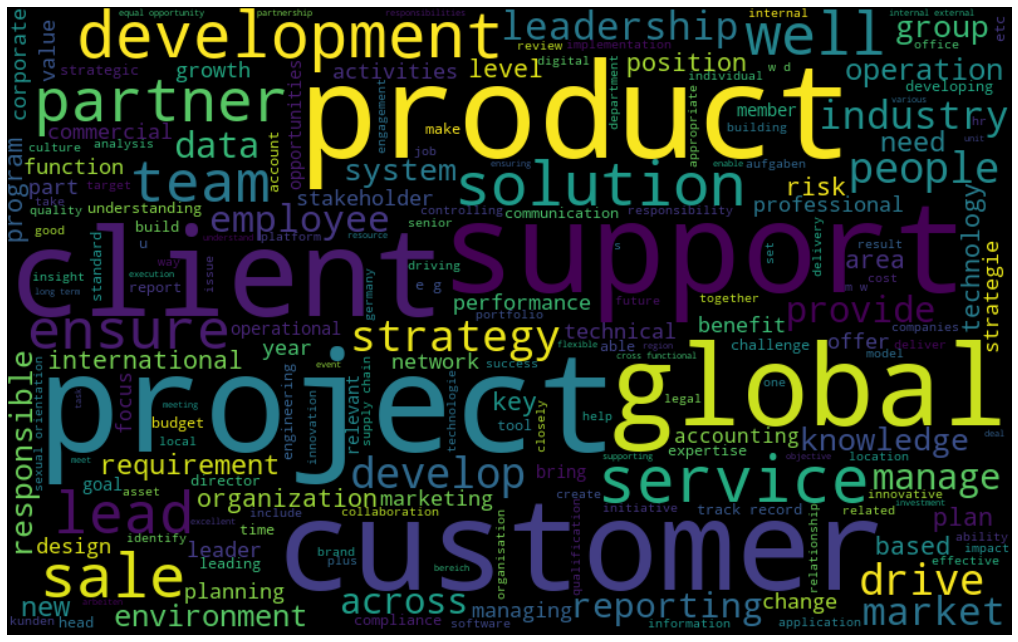

In [30]:
 from wordcloud import WordCloud
 wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
 plt.figure(figsize=(18, 12))
 plt.imshow(wordcloud, interpolation="bilinear")
 plt.axis('off')
 plt.show()

# LDA-Analysis

#### prepare data for analysis >> change: corpus taken only from ONE Keyword

In [31]:
########################
v_num_topics = 20
########################

In [32]:
# For further steps, document corpus must be generated as simple list
# with each list element corresponding to one text from the original data frame

l_docs = df_w2['DOC_TEXT4WC'].tolist()

In [33]:
lemma = WordNetLemmatizer()

In [34]:
l_doc_lem = [f_lematize(doc).split() for doc in l_docs] # corresponds to "doc_clean" in smaple code

In [35]:
corpus = corpora.Dictionary(l_doc_lem)                    # instantiate a corpus dictionary object
mat_doc_term = [corpus.doc2bow(doc) for doc in l_doc_lem] # generate document term matrix !!

#### document term matrix - based LDA model

In [36]:
# ACTUAK LDA-model-training
# Input here the doc term matrix instead of tfidf-matrix
###########################################################################################################

mod_LDA_DocTermMatr = gensim.models.LdaMulticore(mat_doc_term, num_topics=v_num_topics, id2word=corpus, passes=15, workers=2)

###########################################################################################################
# print(mod_LDA_DocTermMatr.print_topics(num_topics=v_num_topics, num_words=15))

#### textual result

In [37]:
print("DocTermMatrix bases LDA-model - Perplexity:-",mod_LDA_DocTermMatr.log_perplexity(mat_doc_term))

DocTermMatrix bases LDA-model - Perplexity:- -8.118529042868209


#### visual result

In [38]:
# pyLDAvis.enable_notebook()
vis_DocTermMatr = gensimvis.prepare(mod_LDA_DocTermMatr, mat_doc_term, corpus)

/home/ulf/anaconda3/envs/ds_xp_10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/ulf/anaconda3/envs/ds_xp_10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/ulf/anaconda3/envs/ds_xp_10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/ulf/anaconda3/envs/ds_xp_10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib an

In [39]:
pyLDAvis.enable_notebook()

In [40]:
vis_DocTermMatr

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.250158  0.074888       1        1  39.840777
16    -0.239877  0.100459       2        1  12.369207
12    -0.214304  0.067030       3        1   9.160671
7      0.281980  0.129260       4        1   7.224198
2      0.262549  0.092624       5        1   4.528381
4      0.273147  0.085092       6        1   4.113889
11     0.236795  0.067928       7        1   3.014987
1     -0.147922  0.031279       8        1   2.889283
10    -0.161086  0.022915       9        1   2.484164
17    -0.139387 -0.006123      10        1   2.095812
9     -0.126787  0.005119      11        1   2.008608
8     -0.148014 -0.009370      12        1   1.944811
6     -0.122079 -0.051444      13        1   1.513536
19    -0.028918 -0.076141      14        1   1.128433
18     0.144532 -0.043396      15        1   1.104636
15     0.007638 -0.084666      16        1   1.075846
5      0.173873 -0.051595      17        1   1.021445
0      0.013103 -0.114255      18        1   0.991778
13     0.042966 -0.068139      19        1   0.897432
3      0.141947 -0.171466      20        1   0.592106, topic_info=           Term         Freq        Total Category  logprob  loglift
840     project   976.000000   976.000000  Default  30.0000  30.0000
3648    product  1203.000000  1203.000000  Default  29.0000  29.0000
261        sale  1139.000000  1139.000000  Default  28.0000  28.0000
3555          ’  1619.000000  1619.000000  Default  27.0000  27.0000
1050     client  1107.000000  1107.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3555          ’     4.903140  1619.312439  Topic20  -5.8220  -0.6706
4971  strategie     2.998547    31.158745  Topic20  -6.3137   2.7883
385   steuerung     3.114434    51.871586  Topic20  -6.2758   2.3165
2910      chain     3.190391   165.151633  Topic20  -6.2517   1.1825
2940     supply     3.033886   236.693307  Topic20  -6.3020   0.7723

[1480 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1242       1  0.907336    #
1242       2  0.004341    #
1242       3  0.008683    #
1242       4  0.013024    #
1242       6  0.008683    #
...      ...       ...  ...
4062      16  0.015065    „
4062      17  0.045194    „
4062      20  0.015065    „
15986      8  0.970629    •
15986     18  0.019413    •

[4807 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 13, 8, 3, 5, 12, 2, 11, 18, 10, 9, 7, 20, 19, 16, 6, 1, 14, 4])